In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

from sentence_transformers import SentenceTransformer
from openai import OpenAI

In [5]:
# Import and Load Dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame({
    'text'  : newsgroups.data,
    'label' : [newsgroups.target_names[i] for i in newsgroups.target]
})

print(f"Shape  : {df.shape}")
print(f"Classes: {df['label'].nunique()}")
print(df['label'].value_counts())
print(df.head(3))

Shape  : (18846, 2)
Classes: 20
label
rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64
                                                text                     label
0  \n\nI am sure some bashers of Pens fans are pr...          rec.sport.hockey
1  My brother is in the market for a high-perform...  comp.sys.ibm.pc.hardware
2  \n\n\n\n\tFinally you said what you dream abou...     ta

[BoW] MNB             → Accuracy: 0.6806  Macro-F1: 0.6555
[BoW] Logistic Reg    → Accuracy: 0.6732  Macro-F1: 0.6659
[BoW] Linear SVM      → Accuracy: 0.6451  Macro-F1: 0.6384
[BoW] Random Forest   → Accuracy: 0.6485  Macro-F1: 0.6285
[TFIDF] MNB             → Accuracy: 0.7029  Macro-F1: 0.6765
[TFIDF] Logistic Reg    → Accuracy: 0.7345  Macro-F1: 0.7219
[TFIDF] Linear SVM      → Accuracy: 0.7607  Macro-F1: 0.7542
[TFIDF] Random Forest   → Accuracy: 0.6501  Macro-F1: 0.6305
Vectorizer         Model  Accuracy  Macro-F1
     TFIDF    Linear SVM    0.7607    0.7542
     TFIDF  Logistic Reg    0.7345    0.7219
     TFIDF           MNB    0.7029    0.6765
       BoW  Logistic Reg    0.6732    0.6659
       BoW           MNB    0.6806    0.6555
       BoW    Linear SVM    0.6451    0.6384
     TFIDF Random Forest    0.6501    0.6305
       BoW Random Forest    0.6485    0.6285


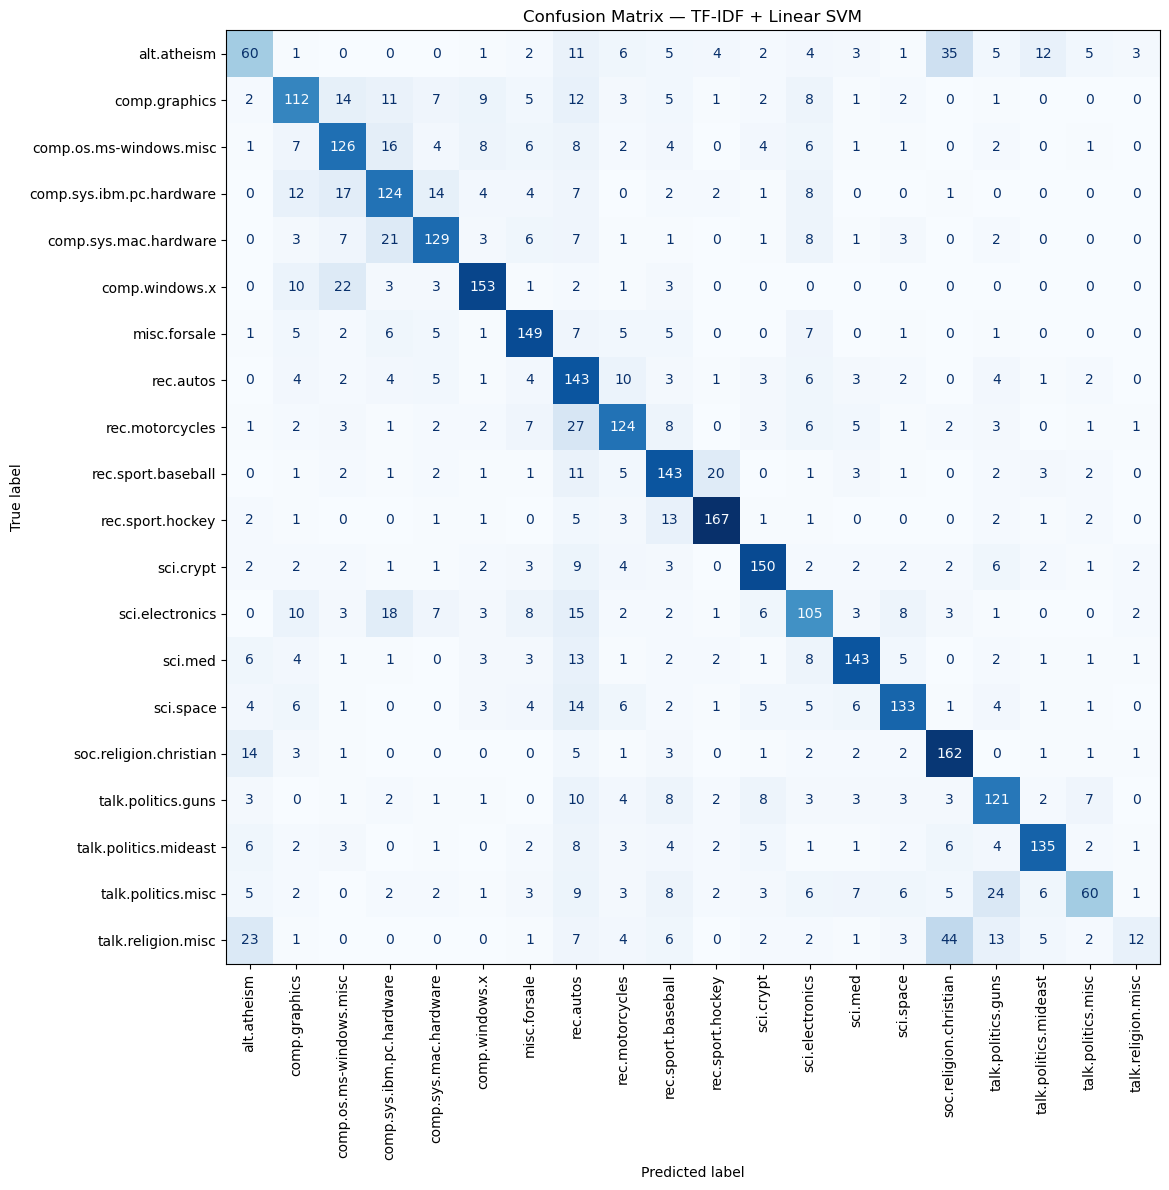

In [12]:
# Part 1 Classic Features: BoW / TF-IDF Classification
X = df['text'].fillna('')
y = df['label']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorizers & Models
vectorizers = {
    'BoW'  : CountVectorizer(max_features=30000),
    'TFIDF': TfidfVectorizer(max_features=30000)
}

models = {
    'MNB'          : MultinomialNB(),
    'Logistic Reg' : LogisticRegression(max_iter=1000, random_state=42),
    'Linear SVM'   : LinearSVC(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train & Evaluate
results = []
for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        pipe = Pipeline([('vec', vectorizer), ('model', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred), 4)
        f1  = round(f1_score(y_test, y_pred, average='macro'), 4)
        results.append({'Vectorizer': vec_name, 'Model': model_name, 'Accuracy': acc, 'Macro-F1': f1})
        print(f"[{vec_name}] {model_name:15s} → Accuracy: {acc}  Macro-F1: {f1}")

# Results table
results_df = pd.DataFrame(results).sort_values('Macro-F1', ascending=False)
print(results_df.to_string(index=False))

# Confusion Matrix for top confusion pair
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, colorbar=False, cmap='Blues')
plt.xticks(rotation=90)
plt.title('Confusion Matrix — TF-IDF + Linear SVM')
plt.tight_layout()
plt.show()

In [18]:
# Part 2 SentenceTransformer Embeddings + Classical Classifiers
# Encode with SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Cache embeddings so you don't re-encode every run
import os
if os.path.exists('embeddings.npy'):
    embeddings = np.load('embeddings.npy')
    print("Loaded embeddings from cache")
else:
    embeddings = model.encode(X.tolist(), batch_size=64, show_progress_bar=True)
    np.save('embeddings.npy', embeddings)
    print("Encoded and saved embeddings")

print(f"Embeddings shape: {embeddings.shape}")

# Train / Test split
from sklearn.model_selection import train_test_split
idx = X.index
X_emb = embeddings[idx]

X_tr, X_te, y_tr, y_te = train_test_split(
    X_emb, y, test_size=0.2, random_state=42, stratify=y
)

# Train & Evaluate
models = {
    'MNB (Gaussian)': GaussianNB(),
    'Logistic Reg'  : LogisticRegression(max_iter=1000, random_state=42),
    'Linear SVM'    : LinearSVC(max_iter=2000, random_state=42),
    'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []
for name, clf in models.items():
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = round(accuracy_score(y_te, y_pred), 4)
    f1  = round(f1_score(y_te, y_pred, average='macro'), 4)
    results.append({'Model': name, 'Accuracy': acc, 'Macro-F1': f1})
    print(f"{name:20s} → Accuracy: {acc}  Macro-F1: {f1}")

results_df = pd.DataFrame(results).sort_values('Macro-F1', ascending=False)
print(results_df.to_string(index=False))

Loaded embeddings from cache
Embeddings shape: (18846, 384)
MNB (Gaussian)       → Accuracy: 0.6846  Macro-F1: 0.675
Logistic Reg         → Accuracy: 0.726  Macro-F1: 0.7149
Linear SVM           → Accuracy: 0.7241  Macro-F1: 0.7098
Random Forest        → Accuracy: 0.6727  Macro-F1: 0.6479
         Model  Accuracy  Macro-F1
  Logistic Reg    0.7260    0.7149
    Linear SVM    0.7241    0.7098
MNB (Gaussian)    0.6846    0.6750
 Random Forest    0.6727    0.6479


K=2  Inertia: 17501
K=3  Inertia: 17100
K=4  Inertia: 16685
K=5  Inertia: 16432
K=6  Inertia: 16214
K=7  Inertia: 16043
K=8  Inertia: 15898
K=9  Inertia: 15759


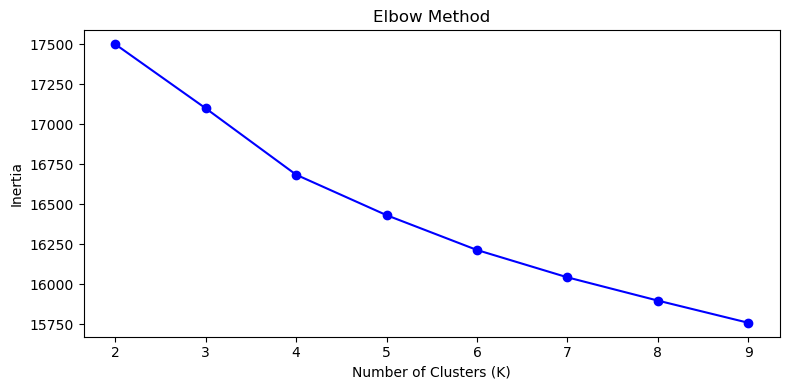

In [20]:
# Part 3 Topic Clustering + 2-Level Topic Tree
# Use the cached embeddings
emb = embeddings[:len(X)]

# Elbow Method to find best K
inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(emb)
    inertias.append(km.inertia_)
    print(f"K={k}  Inertia: {km.inertia_:.0f}")

# Plot elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.tight_layout()
plt.show()

In [21]:
# Fit final KMeans with K=5
K = 5
km = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = km.fit_predict(emb)

# Cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Cluster {c}: {n} documents")

# Find 3 documents closest to each centroid
print("\n── Representative documents per cluster ──")
for c in range(K):
    cluster_idx = np.where(cluster_labels == c)[0]
    cluster_emb = emb[cluster_idx]
    centroid     = km.cluster_centers_[c]
    distances    = np.linalg.norm(cluster_emb - centroid, axis=1)
    closest      = cluster_idx[np.argsort(distances)[:3]]
    print(f"\nCluster {c}:")
    for i, idx in enumerate(closest):
        print(f"  [{i+1}] {X.iloc[idx][:150].strip()}")

Cluster 0: 1747 documents
Cluster 1: 6825 documents
Cluster 2: 523 documents
Cluster 3: 5039 documents
Cluster 4: 4712 documents

── Representative documents per cluster ──

Cluster 0:
  [1] Here are the standings after game 2 of each of the divisional semi-final
series.

	- Andrew

USENET Hockey Playoff Draft Standings

Posn	Team				Pts	R
  [2] I really feel the need for a knowledgable hockey observer to explain this year's playoffs to me. I mean, the obviously superior Toronto team with the
  [3] What are the Leafs to do?  I am a Leaf supporter and
I say the Leafs are going down in four unless there
is nothing short of a miracle or a stroke of

Cluster 1:
  [1] Oh boy, a little K-bike versus /2 scuffling? Grow up! And that goes for
the both of you!

I do hope that the "dump dempster" campaign works however.
I
  [2] [ Article crossposted from sdnet.forsale,rec.motocycle ]
[ Author was Michael James ]
[ Posted on 21 Apr 1993 15:39:50 GMT ]


I must sell my motorcyc
  [3] I looked at th

In [25]:
client = OpenAI(api_key="API_HERE")

def get_label(docs):
    sample = "\n---\n".join([d[:300].strip() for d in docs])
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        max_tokens=10,
        messages=[{
            "role": "user",
            "content": f"Give ONE short 2-4 word topic label (no numbers, no lists) for these documents:\n{sample}\nReply with only the label, nothing else."
        }]
    )
    return response.choices[0].message.content.strip().split("\n")[0]

# Step A: Label top-level clusters
print("=== Top-Level Cluster Labels ===")
top_labels = {}
sizes = {c: np.sum(cluster_labels == c) for c in range(K)}
for c in range(K):
    idx = np.where(cluster_labels == c)[0]
    docs = [X.iloc[i] for i in idx[:5]]
    label = get_label(docs)
    top_labels[c] = label
    print(f"Cluster {c} ({sizes[c]} docs): {label}")

# Step B: Sub-cluster the 2 biggest clusters
top2 = sorted(sizes, key=sizes.get, reverse=True)[:2]

print("\n=== Sub-cluster Labels ===")
sub_labels = {}
for c in top2:
    idx     = np.where(cluster_labels == c)[0]
    sub_emb = emb[idx]
    sub_km  = KMeans(n_clusters=3, random_state=42, n_init=10).fit(sub_emb)
    sub_cls = sub_km.labels_
    sub_labels[c] = {}
    for s in range(3):
        sub_idx  = idx[np.where(sub_cls == s)[0]]
        docs     = [X.iloc[i] for i in sub_idx[:5]]
        sublabel = get_label(docs)
        sub_labels[c][s] = sublabel
        print(f"  Cluster {c} → Sub {s}: {sublabel}")

# Step C: Print topic tree
print("\n=== Topic Tree ===")
for c in range(K):
    print(f"├── [{top_labels[c]}] ({sizes[c]} docs)")
    if c in sub_labels:
        for s, slabel in sub_labels[c].items():
            print(f"│     ├── {slabel}")


=== Top-Level Cluster Labels ===
Cluster 0 (1747 docs): Sports
Cluster 1 (6825 docs): Sacrifice
Cluster 2 (523 docs): Marketing Strategy
Cluster 3 (5039 docs): Video cards
Cluster 4 (4712 docs): Beliefs

=== Sub-cluster Labels ===
  Cluster 1 → Sub 0: Technology
  Cluster 1 → Sub 1: Countersteering 
  Cluster 1 → Sub 2: Technology
  Cluster 3 → Sub 0: Compatibility
  Cluster 3 → Sub 1: High-Performance Video Cards
  Cluster 3 → Sub 2: Graphics Software

=== Topic Tree ===
├── [Sports] (1747 docs)
├── [Sacrifice] (6825 docs)
│     ├── Technology
│     ├── Countersteering 
│     ├── Technology
├── [Marketing Strategy] (523 docs)
├── [Video cards] (5039 docs)
│     ├── Compatibility
│     ├── High-Performance Video Cards
│     ├── Graphics Software
├── [Beliefs] (4712 docs)
